In [29]:
import sys
import matplotlib as m

sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from absl import app
from absl import flags

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_lattice as tfl

In [30]:
from dcc import AAV, Parameters
import numpy as np
import matplotlib.pyplot as plt

p = Parameters()
aav= AAV(p)
ws = np.linspace(0, 200, 100)
ls = np.linspace(0, 5, 100)
ww, ll = np.meshgrid(ws, ls)
z = np.zeros_like(ww)
features = []
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        z[j, i] = -aav.u(ly + 3, wx) - 15
        features.append([ly,wx, z[j, i]])

[INFO] [2020-07-19 21:11:53,395] [AAV] - Instantiated @ AAV


Text(0.5, 1.0, 'vf')

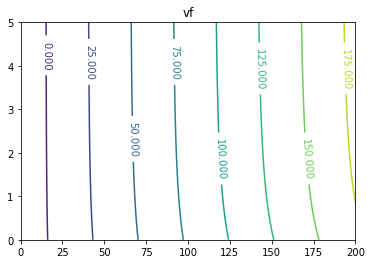

In [31]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('vf')

In [32]:
dataset = pd.DataFrame(features, columns=['l', 'w', 'target'])
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_labels = train_dataset.target.copy()
test_labels = test_dataset.target.copy()
train_dataset = train_dataset.drop(labels=['target'], axis=1)
test_dataset = test_dataset.drop(labels=['target'], axis=1)

Deep lattice

In [33]:
lattice_sizes = [2, 2]
lattice_sizes2 = [2, 2, 2]
lattice_sizes3 = [2, 2]
lattice1 = tfl.layers.Lattice(
    # Number of vertices along each dimension.
    units=3,
    lattice_sizes=lattice_sizes,
    # You can specify monotonicity constraints.
    monotonicities=['increasing', 'increasing'])

lattice2 = tfl.layers.Lattice(
    units=2,
    lattice_sizes=lattice_sizes2,
    # You can specify monotonicity constraints.
    monotonicities=['increasing', 'increasing', 'increasing'])

lattice3 = tfl.layers.Lattice(
    units=1,
    lattice_sizes=lattice_sizes3,
    # You can specify monotonicity constraints.
    monotonicities=['increasing', 'increasing'], output_min=0, output_max=200)

In [34]:
calibrator_w = tfl.layers.PWLCalibration(
  # Every PWLCalibration layer must have keypoints of piecewise linear
  # function specified. Easiest way to specify them is to uniformly cover
  # entire input range by using numpy.linspace().
  input_keypoints=np.linspace(0, 200, num=200),
  units=1,
  # You need to ensure that input keypoints have same dtype as layer input.
  # You can do it by setting dtype here or by providing keypoints in such
  # format which will be converted to deisred tf.dtype by default.
  dtype=tf.float32,
  # Output range must correspond to expected lattice input range.
  output_min=0.0,
  output_max=lattice_sizes[0] - 1.0,
  monotonicity='increasing', convexity='convex')

calibrator_l = tfl.layers.PWLCalibration(
  # Every PWLCalibration layer must have keypoints of piecewise linear
  # function specified. Easiest way to specify them is to uniformly cover
  # entire input range by using numpy.linspace().
  input_keypoints=np.linspace(0, 5, num=100),
  units=1,
  # You need to ensure that input keypoints have same dtype as layer input.
  # You can do it by setting dtype here or by providing keypoints in such
  # format which will be converted to deisred tf.dtype by default.
  dtype=tf.float32,
  # Output range must correspond to expected lattice input range.
  output_min=0.0,
  output_max=lattice_sizes[1] - 1.0,
  monotonicity='increasing', convexity='concave')

combined_calibrators1 = combined_calibrators = tfl.layers.ParallelCombination([calibrator_l, calibrator_w], single_output=True)

calibratorw2 = tfl.layers.PWLCalibration(
  # Every PWLCalibration layer must have keypoints of piecewise linear
  # function specified. Easiest way to specify them is to uniformly cover
  # entire input range by using numpy.linspace().
  input_keypoints=np.linspace(0, 1,num=100),
  units=3,
  # You need to ensure that input keypoints have same dtype as layer input.
  # You can do it by setting dtype here or by providing keypoints in such
  # format which will be converted to deisred tf.dtype by default.
  dtype=tf.float32,
  # Output range must correspond to expected lattice input range.
  output_min=0.0,
  output_max=lattice_sizes2[0] - 1.0,
  monotonicity='increasing')

calibratorw3 = tfl.layers.PWLCalibration(
  # Every PWLCalibration layer must have keypoints of piecewise linear
  # function specified. Easiest way to specify them is to uniformly cover
  # entire input range by using numpy.linspace().
  input_keypoints=np.linspace(0, 1,num=100),
  units=2,
  # You need to ensure that input keypoints have same dtype as layer input.
  # You can do it by setting dtype here or by providing keypoints in such
  # format which will be converted to deisred tf.dtype by default.
  dtype=tf.float32,
  # Output range must correspond to expected lattice input range.
  output_min=0.0,
  output_max=lattice_sizes3[0] - 1.0,
  monotonicity='increasing')

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model = keras.models.Sequential()
# We have just 2 layer as far as Sequential model is concerned.
# PWLConcatenate layer takes care of grouping calibrators.
model.add(combined_calibrators1)
model.add(tf.keras.layers.RepeatVector(3))
model.add(lattice1)
model.add(calibratorw2)
model.add(tf.keras.layers.RepeatVector(2))
model.add(lattice2)
model.add(calibratorw3)
model.add(lattice3)
model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())

In [36]:
x = tf.ones((1, 2))
y = model(x)
y

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[20.500004]], dtype=float32)>

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
parallel_combination_2 (Para multiple                  300       
_________________________________________________________________
repeat_vector_6 (RepeatVecto multiple                  0         
_________________________________________________________________
lattice_7 (Lattice)          multiple                  12        
_________________________________________________________________
pwl_calibration_16 (PWLCalib multiple                  300       
_________________________________________________________________
repeat_vector_7 (RepeatVecto multiple                  0         
_________________________________________________________________
lattice_8 (Lattice)          multiple                  16        
_________________________________________________________________
pwl_calibration_17 (PWLCalib multiple                 

In [38]:
model.fit(train_dataset.to_numpy(), train_labels.to_numpy(), epochs=100,validation_split=0.1, shuffle=False, callbacks=[callback])

Train on 7200 samples, validate on 800 samples
Epoch 1/100
7200/7200 [==============================] - 5s 656us/sample - loss: 101.1447 - val_loss: 7.8819
Epoch 2/100
7200/7200 [==============================] - 1s 101us/sample - loss: 7.6668 - val_loss: 7.6199
Epoch 3/100
7200/7200 [==============================] - 1s 122us/sample - loss: 7.6979 - val_loss: 7.5872
Epoch 4/100
7200/7200 [==============================] - 1s 130us/sample - loss: 7.9136 - val_loss: 7.9794
Epoch 5/100
7200/7200 [==============================] - 1s 132us/sample - loss: 7.9144 - val_loss: 13.8695


Text(0.5, 1.0, 'Simplest default with labels')

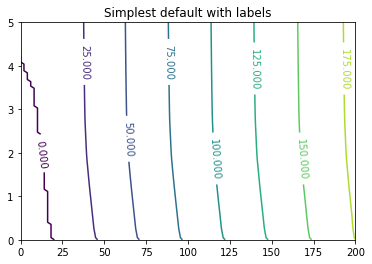

In [39]:
lattice_pred = np.zeros_like(ww)
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        obs = np.array([ly, wx])
        lattice_pred[j, i] = model.predict_on_batch(obs[None,:])
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, lattice_pred)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

In [40]:
model.predict_on_batch(np.array([0.11, 100])[None,:])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[79.59097]], dtype=float32)>

In [41]:
model.predict_on_batch(np.array([1, 100])[None,:])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[82.36096]], dtype=float32)>

## Learning Q-lattice

In [42]:
from dcc import AAV, Parameters
import numpy as np
import matplotlib.pyplot as plt

def transform(x):
    # return ((x*0.8 - 2) + 700)
    return x * 0.1 - 2
aav= AAV(p)
ws = np.linspace(0, 200, 100)
ls = np.linspace(0, 5, 100)
ww, ll = np.meshgrid(ws, ls)
z = np.zeros_like(ww)
zt = np.zeros_like(ww)
features = []
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        z[j, i] = -aav.u(ly, wx)
        zt[j, i] = -aav.u(ly + 3, wx) - 15
        features.append([ly,wx, z[j, i], zt[j, i]])

[INFO] [2020-07-19 21:12:13,688] [AAV] - Instantiated @ AAV


Text(0.5, 1.0, 'vf')

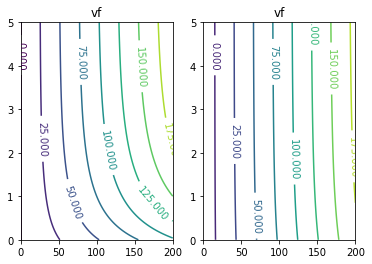

In [43]:
fig, ax = plt.subplots(ncols=2, nrows=1)
CS = ax[0].contour(ww, ll, z)
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title('vf')
CS = ax[1].contour(ww, ll, zt)
ax[1].clabel(CS, inline=1, fontsize=10)
ax[1].set_title('vf')

In [44]:
dataset = pd.DataFrame(features, columns=['l', 'w', 'target', 'target2'])
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_labels = train_dataset[['target', 'target2']].copy()
test_labels = test_dataset[['target', 'target2']].copy()
train_dataset = train_dataset.drop(labels=['target', 'target2'], axis=1)
test_dataset = test_dataset.drop(labels=['target', 'target2'], axis=1)

In [45]:
# all lattice sizes will be cubes, i.e., same number of dimensions


max_w = 200
max_l = 5

lattice_units_layer = [3, 3, 3, 2]

n_lattice_points=[3, 3, 3, 3]

lattice1 = tfl.layers.Lattice(units=lattice_units_layer[0], lattice_sizes=[n_lattice_points[0]]*2, monotonicities=2*['increasing'], output_min=0, output_max=1)

lattice2 = tfl.layers.Lattice(
    units=lattice_units_layer[1],
    lattice_sizes=[n_lattice_points[1]]*lattice_units_layer[0],
    monotonicities=['increasing']*lattice_units_layer[0], output_min=0, output_max=1)

lattice3 = tfl.layers.Lattice(
    units=lattice_units_layer[2],
    lattice_sizes=[n_lattice_points[2]]*lattice_units_layer[1],
    # You can specify monotonicity constraints.
    monotonicities=['increasing']*lattice_units_layer[1], output_min=0, output_max=1)

lattice4 = tfl.layers.Lattice(
    units=lattice_units_layer[3],
    lattice_sizes=[n_lattice_points[3]]*lattice_units_layer[2],
    # You can specify monotonicity constraints.
    monotonicities=['increasing']*lattice_units_layer[2], output_min=0, output_max=1)


combined_calibrators = []
    
for i in range(lattice_units_layer[0]):
    calibration_layer_l = tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, max_l, num=100), dtype=tf.float32, output_min=0.0, output_max=n_lattice_points[0] - 1.0, 
                                                    monotonicity='increasing')#, convexity='concave')
    calibration_layer_w = tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, max_w, num=100), dtype=tf.float32, output_min=0.0, output_max=n_lattice_points[0] - 1.0,
                                                    monotonicity='increasing')#, convexity='convex')
    combined_calibrators.append(calibration_layer_l)
    combined_calibrators.append(calibration_layer_w)
    
input_callibrators = tfl.layers.ParallelCombination(combined_calibrators, single_output=True)   

calibrator2 = tfl.layers.PWLCalibration(
  input_keypoints=np.linspace(0, 1, num=50),
  units=lattice_units_layer[0] * lattice_units_layer[1],
  dtype=tf.float32,
  output_min=0.0,
  output_max=n_lattice_points[1] - 1.0,
  monotonicity='increasing')

calibrator3 = tfl.layers.PWLCalibration(
  input_keypoints=np.linspace(0, 1, num=50),
  units=lattice_units_layer[1] * lattice_units_layer[2],
  dtype=tf.float32,
  output_min=0.0,
  output_max=n_lattice_points[2] - 1.0,
  monotonicity='increasing')

calibrator4 = tfl.layers.PWLCalibration(
  input_keypoints=np.linspace(0, 1, num=50),
  units=lattice_units_layer[2] * lattice_units_layer[3],
  dtype=tf.float32,
  output_min=0.0,
  output_max=n_lattice_points[3] - 1.0,
  monotonicity='increasing')


calibratorf = tfl.layers.PWLCalibration(
  # Every PWLCalibration layer must have keypoints of piecewise linear
  # function specified. Easiest way to specify them is to uniformly cover
  # entire input range by using numpy.linspace().
  input_keypoints=np.linspace(0, 1, num=100),
  units=2,
  # You need to ensure that input keypoints have same dtype as layer input.
  # You can do it by setting dtype here or by providing keypoints in such
  # format which will be converted to deisred tf.dtype by default.
  dtype=tf.float32,
  # Output range must correspond to expected lattice input range.
  output_min=0.0,
  monotonicity='increasing')

In [46]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model = keras.models.Sequential()
model.add(tf.keras.layers.RepeatVector(lattice_units_layer[0]))
model.add(tf.keras.layers.Flatten())
model.add(input_callibrators)
model.add(tf.keras.layers.Reshape((lattice_units_layer[0], 2)))
model.add(lattice1)
model.add(tf.keras.layers.RepeatVector(lattice_units_layer[1]))
model.add(tf.keras.layers.Flatten())
model.add(calibrator2)
model.add(tf.keras.layers.Reshape((lattice_units_layer[1], lattice_units_layer[0])))
model.add(lattice2)
model.add(tf.keras.layers.RepeatVector(lattice_units_layer[2]))
model.add(tf.keras.layers.Flatten())
model.add(calibrator3)
model.add(tf.keras.layers.Reshape((lattice_units_layer[2], lattice_units_layer[1])))
model.add(lattice3)
model.add(tf.keras.layers.RepeatVector(lattice_units_layer[3]))
model.add(tf.keras.layers.Flatten())
model.add(calibrator4)
model.add(tf.keras.layers.Reshape((lattice_units_layer[3], lattice_units_layer[2])))
model.add(lattice4)
model.add(calibratorf)
model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())

In [47]:
x = tf.ones((1, 2))
y = model(x)
y

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>

In [48]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector_8 (RepeatVecto multiple                  0         
_________________________________________________________________
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
parallel_combination_3 (Para multiple                  600       
_________________________________________________________________
reshape_4 (Reshape)          multiple                  0         
_________________________________________________________________
lattice_10 (Lattice)         multiple                  27        
_________________________________________________________________
repeat_vector_9 (RepeatVecto multiple                  0         
_________________________________________________________________
flatten_5 (Flatten)          multiple                 

In [49]:
# import pydot
# from keras.utils.vis_utils import plot_model
# plot_model(model, rankdir='LR')

In [50]:
model.fit(train_dataset.to_numpy(), train_labels.to_numpy(), epochs=50, validation_split=0.1, shuffle=False, callbacks=[callback])

Train on 7200 samples, validate on 800 samples
Epoch 1/50
7200/7200 [==============================] - 6s 809us/sample - loss: 8192.3495 - val_loss: 6176.1156
Epoch 2/50
7200/7200 [==============================] - 1s 137us/sample - loss: 5461.7267 - val_loss: 4139.8033
Epoch 3/50
7200/7200 [==============================] - 1s 135us/sample - loss: 3706.2875 - val_loss: 2805.0744
Epoch 4/50
7200/7200 [==============================] - 1s 130us/sample - loss: 2535.4716 - val_loss: 1919.3963
Epoch 5/50
7200/7200 [==============================] - 1s 131us/sample - loss: 1747.4247 - val_loss: 1329.8762
Epoch 6/50
7200/7200 [==============================] - 1s 135us/sample - loss: 1216.3371 - val_loss: 932.9330
Epoch 7/50
7200/7200 [==============================] - 1s 134us/sample - loss: 856.7409 - val_loss: 664.3443
Epoch 8/50
7200/7200 [==============================] - 1s 134us/sample - loss: 612.5162 - val_loss: 479.0102
Epoch 9/50
7200/7200 [==============================] - 1s 135

Text(0.5, 1.0, 'vf')

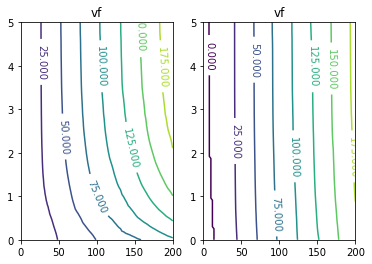

In [51]:
lattice_pred = np.zeros_like(ww)
lattice_pred2 = np.zeros_like(ww)
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        obs = np.array([ly, wx])
        pred = model.predict_on_batch(obs[None,:]).numpy()
        lattice_pred[j, i] = pred[0][0]
        lattice_pred2[j, i] = pred[0][1]
fig, ax = plt.subplots(ncols=2, nrows=1)

CS = ax[0].contour(ww, ll, lattice_pred)
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title('vf')
CS = ax[1].contour(ww, ll, lattice_pred2)
ax[1].clabel(CS, inline=1, fontsize=10)
ax[1].set_title('vf')

Text(0.5, 1.0, 'vf')

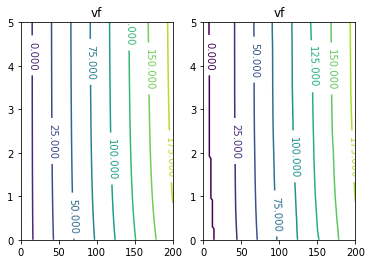

In [52]:
fig, ax = plt.subplots(ncols=2, nrows=1)

CS = ax[0].contour(ww, ll, zt)
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title('vf')
CS = ax[1].contour(ww, ll, lattice_pred2)
ax[1].clabel(CS, inline=1, fontsize=10)
ax[1].set_title('vf')


<a list of 15 text.Text objects>

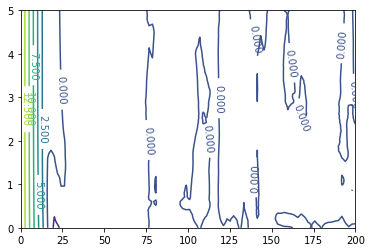

In [53]:
CS = plt.contour(ww, ll,lattice_pred2-zt)
plt.clabel(CS, inline=1, fontsize=10)

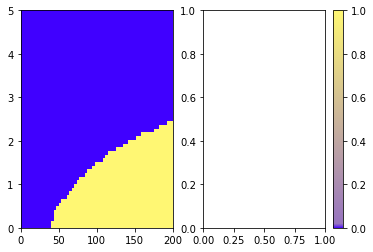

In [54]:
def plot_policy():
    w_points = 60
    l_points = 60
    l = np.linspace(0, 5, l_points)
    w = np.linspace(0, 200, w_points)
    ww, ll = np.meshgrid(w, l)
    z = np.zeros_like(ww)
    p = np.zeros_like(ww)
    for i, xp in enumerate(w):
        for j, yp in enumerate(l):
            fixed_obs = np.array([yp, xp])
            z[j, i] = np.argmax(model.predict_on_batch(fixed_obs[None, :]).numpy().flatten())

    fig, ax = plt.subplots(nrows=1, ncols=2)
    im = ax[0].pcolor(ww, ll, z)
    cdict = {
        'red': ((0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
        'green': ((0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
        'blue': ((0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
    }

    cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)
    im = ax[0].pcolor(ww, ll, z, cmap=cm)
    fig.colorbar(im)



plot_policy()

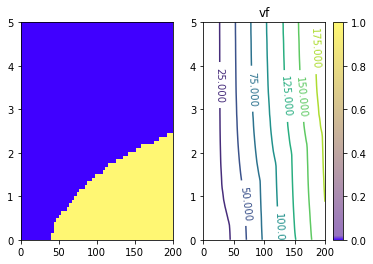

In [55]:
w_points = 60
l_points = 60
l = np.linspace(0, 5, l_points)
w = np.linspace(0, 200, w_points)
ww, ll = np.meshgrid(w, l)
z = np.zeros_like(ww)
p = np.zeros_like(ww)
for i, xp in enumerate(w):
    for j, yp in enumerate(l):
        fixed_obs = np.array([yp, xp])
        z[j, i] = np.argmax(model.predict_on_batch(fixed_obs[None, :]).numpy().flatten())
        p[j, i] = np.amax(model.predict_on_batch(fixed_obs[None, :]))

fig, ax = plt.subplots(nrows=1, ncols=2)
im = ax[0].pcolor(ww, ll, z)
cdict = {
    'red': ((0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
    'green': ((0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
    'blue': ((0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}

cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)
im = ax[0].pcolor(ww, ll, z, cmap=cm)

CS = plt.contour(ww, ll, p)
ax[1].clabel(CS, inline=1, fontsize=10)
ax[1].set_title('vf')

fig.colorbar(im)

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

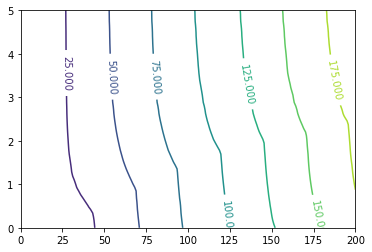

In [56]:
CS = plt.contour(ww, ll, p)
plt.clabel(CS, inline=1, fontsize=10)
plt.set_title('vf')

In [ ]:
model2 = tf.keras.models.clone_model(model)

In [ ]:
model2.build(input_shape=(1, 2))

In [ ]:
model2.set_weights(model.get_weights())

In [ ]:
def plot_policy():
    w_points = 60
    l_points = 60
    l = np.linspace(0, 5, l_points)
    w = np.linspace(0, 200, w_points)
    ww, ll = np.meshgrid(w, l)
    z = np.zeros_like(ww)
    p = np.zeros_like(ww)
    for i, xp in enumerate(w):
        for j, yp in enumerate(l):
            fixed_obs = np.array([yp, xp])
            z[j, i] = np.argmax(model2.predict_on_batch(fixed_obs[None, :]).numpy().flatten())

    fig, ax = plt.subplots(nrows=1, ncols=2)
    im = ax[0].pcolor(ww, ll, p)
    cdict = {
        'red': ((0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
        'green': ((0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
        'blue': ((0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
    }

    cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)
    im = ax[0].pcolor(ww, ll, z, cmap=cm)
    fig.colorbar(im)



plot_policy()